In [18]:
from scipy.sparse import hstack, csr_matrix
from tqdm import tqdm
import numpy as np
import pandas as pd
import re

from collections import Counter
from collections import defaultdict
from scipy import sparse
from scipy.stats import uniform

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Part 1: Representing Text Data

In [19]:
df_train = pd.read_csv("data/train.csv")
df_dev = pd.read_csv("data/dev.csv")
df_test = pd.read_csv("data/test.csv")

## Task 1.1: Tokenization

In [20]:
stop_words = {
    'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 
    'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 
    'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 
    'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 
    'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 
    'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 
    'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 
    'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 
    'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 
    'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 
    'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 
    'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 
    'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than',
    '<h>', '</h>'
}

stop_punctuations = '''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~—'''

In [21]:
def tokenize(text):
    # Split the text by whitespace and return the list of tokens
    return text.split()

def better_tokenize(input_str, punctuations=stop_punctuations, stopwords=stop_words):
    # Remove line breaks and filter out <> enclosed text
    cleaned_str = re.sub(r'\n|\<[^<>]*\>', '', input_str)

    # Remove punctuations
    for punctuation in punctuations:
        cleaned_str = cleaned_str.replace(punctuation, '')

    # Convert to lowercase and split into words
    words = cleaned_str.lower().split()

    # Filter out stopwords
    filtered_words = filter(lambda word: word not in stopwords, words)

    return list(filtered_words)

In [22]:
input_str = "Your sample text goes here."
tokens = better_tokenize(input_str)
print(tokens)

['sample', 'text', 'goes']


## Task 1.2: Building the Term-Document Matrix

In [23]:
def build_term_freq_dict(dataframe, text_col, min_freq=2):
    term_counter = Counter()

    # Iterate through each document and update term frequencies
    for document in dataframe[text_col]:
        terms = better_tokenize(document)
        term_counter.update(terms)

    # Retain terms that meet the minimum frequency threshold
    filtered_terms = {term: freq for term, freq in term_counter.items() if freq >= min_freq}

    return filtered_terms

# Example usage
term_dictionary = build_term_freq_dict(df_train, 'text', 10)

In [24]:
def createCompressedSparseRowMatrix(documents, vocab={}, frequencyFilter=term_dictionary):
    rowStart = [0]
    colIndices = []
    values = []

    print("Constructing compressed sparse row (CSR) matrix...")
    for document in tqdm(documents):
        for word in document:
            if word in frequencyFilter:  # Exclude terms with low frequency
                wordIndex = vocab[word] if word in vocab else len(vocab)
                vocab[word] = wordIndex
                colIndices.append(wordIndex)
                values.append(1)
        rowStart.append(len(colIndices))

    csrMatrix = sparse.csr_matrix((values, colIndices, rowStart), dtype=int)
    return csrMatrix, vocab

In [25]:
# Prepare the document list
document_list = []
print("Creating document list for training...")
for idx, record in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    document_list.append(better_tokenize(record["text"]))

# Generate the CSR matrix
training_matrix, training_vocab = createCompressedSparseRowMatrix(document_list)

# Add a bias column to the matrix
bias_column = np.ones((training_matrix.shape[0], 1))
training_matrix_with_bias = sparse.hstack([training_matrix, bias_column]).tocsr()

Creating document list for training...


100%|██████████| 7328/7328 [00:00<00:00, 17078.07it/s]


Constructing compressed sparse row (CSR) matrix...


100%|██████████| 7328/7328 [00:00<00:00, 157099.35it/s]


# Part 2: Logistic Regression in numpy

In [26]:
def sigmoid(X):
    # Using np.exp for element-wise exponential
    return np.divide(1, np.add(1, np.exp(np.negative(X))))

def log_likelihood(X, y, beta):
    sum = 0
    for i in range(X.shape[0]):  # 遍历样本
        x_i = X[i].toarray().flatten()
        sum += y[i] * np.dot(beta, x_i) - np.log10(1 + np.exp(np.dot(beta, x_i)))
    return sum

def compute_gradient(x, y, beta):
    # Using np.subtract and np.outer for vectorized operations
    prediction_error = np.subtract(sigmoid(np.dot(beta, x)), y)
    gradient = np.multiply(prediction_error, x)
    return gradient

In [27]:
def logistic_regression(X, y, learning_rate=5e-5, num_step=1000, is_plot=False):
    # Initialize variables
    vocab_size = X.shape[1]  # Size of the vocabulary
    beta_params = np.zeros(vocab_size)  # Initializing beta parameters
    prev_log_likelihood = log_likelihood(X, y, beta_params)  # Initial log-likelihood

    # Initialize plot-related lists if plotting is enabled
    steps, log_likelihoods = ([], []) if is_plot else (None, None)

    print("Running Logistic Regression...")
    for step in tqdm(range(num_step)):
        # Update beta using a gradient step
        current_index = step % vocab_size
        X_sample = X[current_index].toarray().ravel()
        y_sample = y[current_index]
        gradient = compute_gradient(X_sample, y_sample, beta_params)
        beta_params -= learning_rate * gradient

        # Record log-likelihood and step count at every 100th step
        if is_plot and step % 100 == 0:
            steps.append(step)
            log_likelihoods.append(log_likelihood(X, y, beta_params))

    # Return results based on whether plotting is enabled
    return (beta_params, steps, log_likelihoods) if is_plot else beta_params

In [28]:
def predict(text, model_coefficients, vocabulary=training_vocab):
    feature_vector = np.zeros(len(vocabulary) + 1)
    
    word_counts = Counter(better_tokenize(text))
    for word, count in word_counts.items():
        if word in vocabulary:
            feature_vector[vocabulary[word]] = count
    feature_vector[-1] = 1  # Add bias term

    prediction = sigmoid(np.dot(model_coefficients, feature_vector))
    return int(prediction >= 0.152)

## Task 2.1: Plot log-likelihood

In [29]:
# Mapping labels
label_map = {0: 0, 1: 1}
train_labels = np.array([label_map[label] for label in df_train['label']])

# Perform logistic regression
regression_beta, iteration_steps, log_likelihoods = logistic_regression(
    X=training_matrix_with_bias,
    y=train_labels,
    num_step=10000,
    is_plot=True
)


Running Logistic Regression...


100%|██████████| 10000/10000 [00:45<00:00, 217.60it/s]


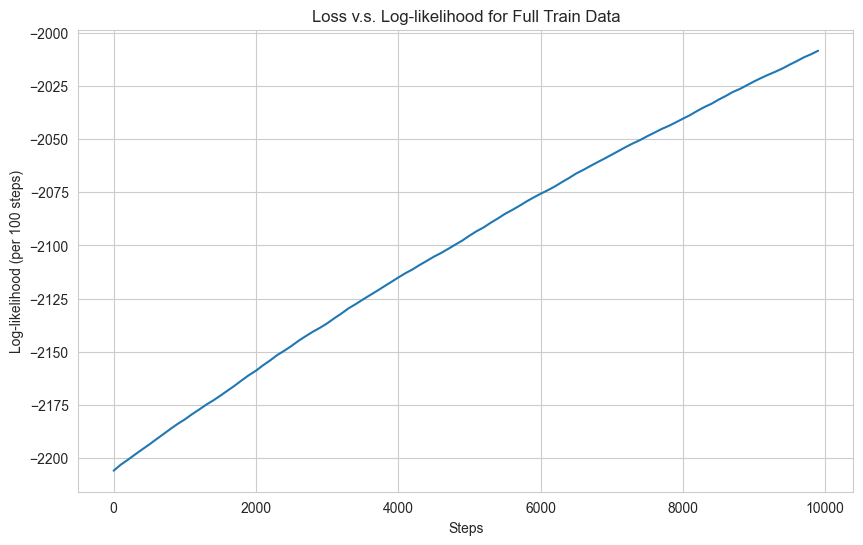

In [30]:
# Plotting the relationship between steps and log-likelihood
fig, plot_axis = plt.subplots(figsize=(10, 6))
sns.lineplot(x=iteration_steps, y=log_likelihoods, ax=plot_axis)
plot_axis.set_xlabel("Steps")
plot_axis.set_ylabel("Log-likelihood (per 100 steps)")
plot_axis.set_title("Loss v.s. Log-likelihood for Full Train Data")
plt.show()

## Task 2.2: Make prediction on validation dataset

In [31]:
# train the beta
beta = logistic_regression(X = training_matrix_with_bias,
                           y = train_labels, 
                           learning_rate = 5e-5, 
                           num_step = 500000)

Running Logistic Regression...


100%|██████████| 500000/500000 [00:35<00:00, 13894.92it/s]


In [32]:
# make prediction
y_test = [label_map[p] for p in df_dev["label"]]
y_pred = []
print("Starting prediction on validation dataset...")
for i in tqdm(range(len(df_dev))):
    y_pred.append(predict(df_dev["text"][i], beta))

Starting prediction on validation dataset...


100%|██████████| 1047/1047 [00:00<00:00, 24028.04it/s]


In [33]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.3626373626373627

## Task 2.3: Make prediction on test dataset

In [34]:
# Reverse label dictionary
label_reverse_map = {0: 0, 1: 1}

# Function to predict labels
def make_predictions(data):
    predictions = []
    print("Predicting labels for test dataset...")
    for index, row in tqdm(data.iterrows(), total=len(data)):
        text_content = str(row['text'])
        predictions.append(predict(text_content, beta))
    return predictions

# Generate predictions
predicted_labels = make_predictions(df_test)

# Create result dataframe and save to CSV
result_df = pd.DataFrame({
    'par_id': df_test['par_id'],
    'label': [label_reverse_map[label] for label in predicted_labels]
})
result_df.to_csv("part2_result.csv", index=False)

Predicting labels for test dataset...


100%|██████████| 2094/2094 [00:00<00:00, 11135.94it/s]
